In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import os

import src.utils as utils
from src.model import Nonneg_dagma, MetMulDagma

from baselines.colide import colide_ev
from baselines.dagma_linear import DAGMA_linear
from baselines.notears import notears_linear


PATH = './results/size/'
SAVE = True
SEED = 10
N_CPUS = os.cpu_count()
np.random.seed(SEED)

## Auxiliary functions

In [2]:
# Experiment function
def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def run_size_exp(g, data_p, Sizes, exps, thr=.2, verb=False):
    shd, tpr, fdr, fscore, err, acyc, runtime, dag_count = [np.zeros((len(Sizes), len(exps)))  for _ in range(8)]
    for i, n_nodes in enumerate(Sizes):
        if g % N_CPUS == 0:
            print(f'Graph: {g+1}, Nodes: {n_nodes}')

        # Create data
        data_p_aux = data_p.copy()
        data_p_aux['n_nodes'] = n_nodes
        data_p_aux['edges'] *= n_nodes
        data_p_aux['var'] = 1/np.sqrt(n_nodes) if data_p_aux['var'] is None else data_p_aux['var']
        data_p_aux['n_samples'] = 10*n_nodes if data_p_aux['n_samples'] is None else data_p_aux['n_samples']

        W_true, _, X = utils.simulate_sem(**data_p_aux)
        X_std = utils.standarize(X)
        W_true_bin = utils.to_bin(W_true, thr)
        norm_W_true = np.linalg.norm(W_true)

        for j, exp in enumerate(exps):
            X_aux = X_std if 'standarize' in exp.keys() and exp['standarize'] else X


            arg_aux = exp['args'].copy()
            if 'adapt_lamb' in exp.keys() and exp['adapt_lamb']:
                if 'lamb' in arg_aux.keys():
                    arg_aux['lamb'] = get_lamb_value(n_nodes, data_p_aux['n_samples'], arg_aux['lamb'])
                elif 'lambda1' in arg_aux.keys():
                    arg_aux['lambda1'] = get_lamb_value(n_nodes, data_p_aux['n_samples'], arg_aux['lambda1'])

            if exp['model'] == notears_linear:
                t_init = perf_counter()
                W_est = notears_linear(X_aux, **arg_aux)
                t_end = perf_counter()
            else:
                model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
                t_init = perf_counter()
                model.fit(X_aux, **arg_aux)
                t_end = perf_counter()
                
                W_est = model.W_est

            if np.isnan(W_est).any():
                W_est = np.zeros_like(W_est)
                W_est_bin = np.zeros_like(W_est)
            else:
                W_est_bin = utils.to_bin(W_est, thr)
            
            shd[i,j], tpr[i,j], fdr[i,j] = utils.count_accuracy(W_true_bin, W_est_bin)
            shd[i,j] /= n_nodes
            fscore[i,j] = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
            err[i,j] = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
            acyc[i,j] = model.dagness(W_est) if hasattr(model, 'dagness') else 1
            runtime[i,j] = t_end - t_init
            dag_count[i,j] += 1 if utils.is_dag(W_est_bin) else 0
        
            if verb and (g % N_CPUS == 0):
                print(f'\t\t-{exp["leg"]}: shd {shd[i,j]}  -  err: {err[i,j]:.3f}  -  time: {runtime[i,j]:.3f}')

    return shd, tpr, fdr, fscore, err, acyc, runtime, dag_count

In [3]:
n_dags = 50
thr = .2
verb = True
Sizes = [50, 75, 100, 250, 500, 1000]

# DEFINE EXPERIMENTS
Exps = [
  # Convex
  # ## Best models for weights (.5, 1)
  # {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
  #  'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
  #  'adapt_lamb': True, 'standarize': False, 'fmt': 'o-', 'leg': 'MM-Logdet'},

  # {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
  #  'iters_in': 15000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
  #  'adapt_lamb': True, 'standarize': False, 'fmt': 'o-', 'leg': 'MM-Logdet-v2'},

  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
   'iters_in': 10000, 'iters_out': 15, 'beta': 5}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
   'adapt_lamb': True, 'standarize': False, 'fmt': 'o-', 'leg': 'MM-Logdet'},

  {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
   'iters_in': 15000, 'iters_out': 10, 'beta': 5}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
   'adapt_lamb': True, 'standarize': False, 'fmt': 'o-', 'leg': 'MM-Logdet-v2'},

  # DAGMA
  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': '^-', 'leg': 'DAGMA'},
]

## 4N Edges - weights (.5, 1)

In [12]:
# NOTE: larger beta required for larger weights
data_p = {
    'edges': 4,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
    'n_samples': 1000,
}

### Estimate graphs

#### Erdos Renyi

In [ ]:
data_p['graph_type'] = 'er'

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_er4 = Parallel(n_jobs=N_CPUS)(delayed(run_size_exp)
                                  (g, data_p, Sizes, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

shd_er4, tpr_er4, fdr_er4, fscore_er4, err_er4, acyc_er4, runtime_er4, dag_count_er4 = zip(*results_er4)

CPUs employed: 128
Graph: 1, Nodes: 50
		-MM-Logdet: shd 0.0  -  err: 0.006  -  time: 10.038
		-MM-Logdet-fix: shd 14.0  -  err: 0.067  -  time: 8.676
		-DAGMA: shd 59.0  -  err: 0.202  -  time: 11.974
Graph: 1, Nodes: 100
		-MM-Logdet: shd 0.0  -  err: 0.003  -  time: 15.679
		-MM-Logdet-fix: shd 1.0  -  err: 0.011  -  time: 16.340
		-DAGMA: shd 12.0  -  err: 0.031  -  time: 17.405
Graph: 1, Nodes: 500
		-MM-Logdet: shd 55.0  -  err: 0.017  -  time: 1800.288
		-MM-Logdet-fix: shd 44.0  -  err: 0.015  -  time: 1440.852
		-DAGMA: shd 216.0  -  err: 0.080  -  time: 2786.762
----- Solved in 127.295 minutes -----


In [ ]:
if SAVE:
    file_name = PATH + f'size_ERgraph_{data_p["edges"]}N_{data_p["w_range"][1]}w'
    np.savez(file_name, shd=shd_er4, tpr=tpr_er4, fdr=fdr_er4, fscore=fscore_er4, err=err_er4,
             acyc=acyc_er4, runtime=runtime_er4, dag_count=dag_count_er4, exps=Exps,
             xvals=Sizes)
    print('SAVED in file:', file_name)

#### Scale free

In [ ]:
data_p['graph_type'] = 'sf'

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count =\
      [np.zeros((n_dags, len(Sizes), len(Exps)))  for _ in range(8)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results_sf4 = Parallel(n_jobs=N_CPUS)(delayed(run_size_exp)
                                  (g, data_p, Sizes, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

shd_sf4, tpr_sf4, fdr_sf4, fscore_sf4, err_sf4, acyc_sf4, runtime_sf4, dag_count_sf4 = zip(*results_sf4)

CPUs employed: 128
Graph: 1, Nodes: 50
Graph: 1, Nodes: 100
Graph: 1, Nodes: 500


KeyboardInterrupt: 

In [ ]:
if SAVE:
    file_name = PATH + f'size_SFgraph_{data_p["edges"]}N_{data_p["w_range"][1]}w'
    np.savez(file_name, shd=shd_sf4, tpr=tpr_sf4, fdr=fdr_sf4, fscore=fscore_sf4, err=err_sf4,
             acyc=acyc_sf4, runtime=runtime_sf4, dag_count=dag_count_sf4, exps=Exps,
             xvals=Sizes)
    print('SAVED in file:', file_name)

### Plot results

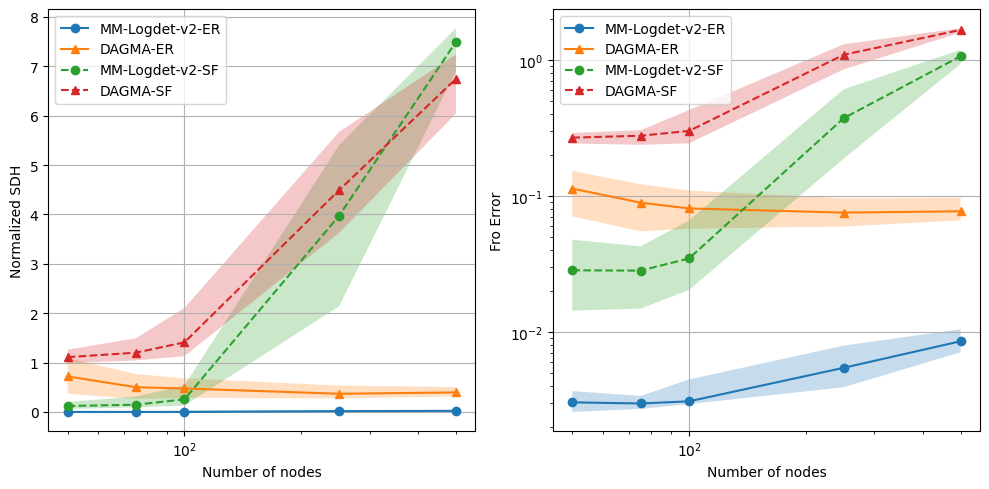

In [ ]:
### Weights (.5, 1.5) ###
# # Load Data
# file_name = "./results/size/size_ERgraph_4N_1.5w.npz"
# data = np.load(file_name, allow_pickle=True)
# Exps, shd_er4, tpr_er4, fdr_er4, fscore_er4, err_er4, acyc_er4, runtime_er4, dag_count_er4, Sizes = data['exps'], data['shd'], data['tpr'], \
#     data['fdr'], data['fscore'], data['err'], data['acyc'], data['runtime'], data['dag_count'], data['xvals']

# file_name = "./results/size/size_SFgraph_4N_1.5w.npz"
# data = np.load(file_name, allow_pickle=True)
# Exps, shd_sf4, tpr_sf4, fdr_sf4, fscore_sf4, err_sf4, acyc_sf4, runtime_sf4, dag_count_sf4, Sizes = data['exps'], data['shd'], data['tpr'], \
#     data['fdr'], data['fscore'], data['err'], data['acyc'], data['runtime'], data['dag_count'], data['xvals']

skip = [0, 3]
Exps_er = [{'leg': exp['leg'] + '-ER', 'fmt': exp['fmt'][0] + '-'} for exp in Exps]
Exps_sf = [{'leg': exp['leg'] + '-SF', 'fmt': exp['fmt'][0] + '--'} for exp in Exps]
Exps_joint = Exps_er + Exps_sf

shd = np.concatenate((shd_er4, shd_sf4), axis=2)
err = np.concatenate((err_er4, err_sf4), axis=2)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps_joint, Sizes, 'Number of nodes', 'Normalized SDH', skip,
                agg='median', deviation='prctile', alpha=0.25)
utils.plot_data(axes[1], err, Exps_joint, Sizes, 'Number of nodes', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()
# plt.savefig(PATH + f'size.png')

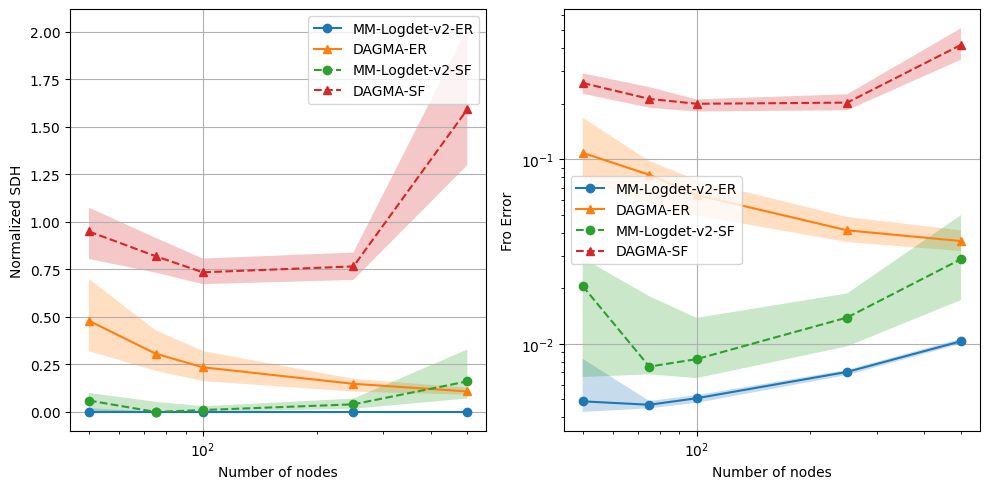

In [ ]:
### Weights (.5, 1) ###
# Load Data
file_name = "./results/size/size_ERgraph_4N.npz"
data = np.load(file_name, allow_pickle=True)
Exps, shd_er4, tpr_er4, fdr_er4, fscore_er4, err_er4, acyc_er4, runtime_er4, dag_count_er4, Sizes = data['exps'], data['shd'], data['tpr'], \
    data['fdr'], data['fscore'], data['err'], data['acyc'], data['runtime'], data['dag_count'], data['xvals']

file_name = "./results/size/size_SFgraph_4N.npz"
data = np.load(file_name, allow_pickle=True)
Exps, shd_sf4, tpr_sf4, fdr_sf4, fscore_sf4, err_sf4, acyc_sf4, runtime_sf4, dag_count_sf4, Sizes = data['exps'], data['shd'], data['tpr'], \
    data['fdr'], data['fscore'], data['err'], data['acyc'], data['runtime'], data['dag_count'], data['xvals']

skip = [0, 3]
Exps_er = [{'leg': exp['leg'] + '-ER', 'fmt': exp['fmt'][0] + '-'} for exp in Exps]
Exps_sf = [{'leg': exp['leg'] + '-SF', 'fmt': exp['fmt'][0] + '--'} for exp in Exps]
Exps_joint = Exps_er + Exps_sf

shd = np.concatenate((shd_er4, shd_sf4), axis=2)
err = np.concatenate((err_er4, err_sf4), axis=2)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps_joint, Sizes, 'Number of nodes', 'Normalized SDH', skip,
                agg='median', deviation='prctile', alpha=0.25)
utils.plot_data(axes[1], err, Exps_joint, Sizes, 'Number of nodes', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()
# plt.savefig(PATH + f'size.png')

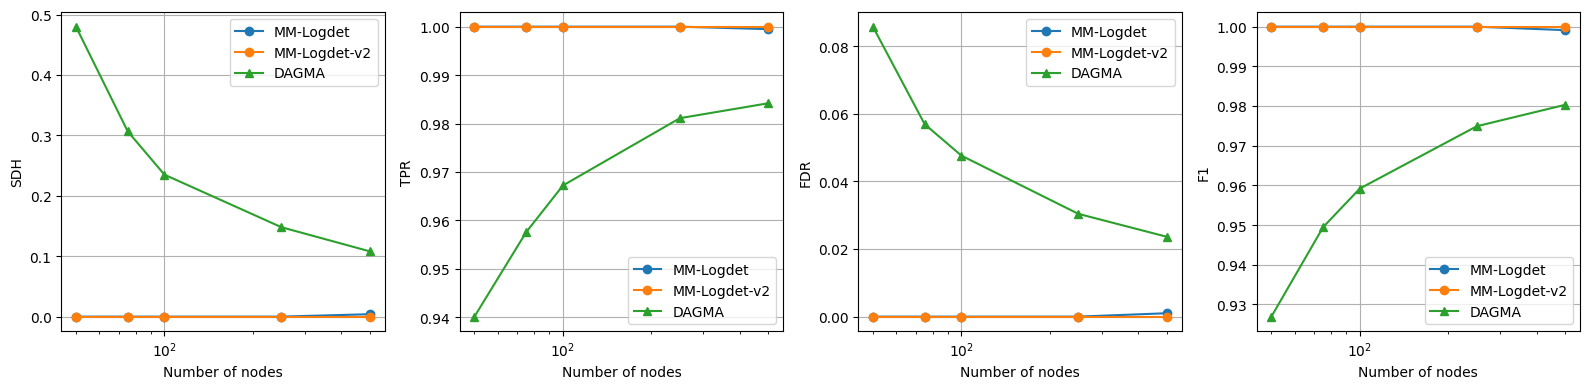

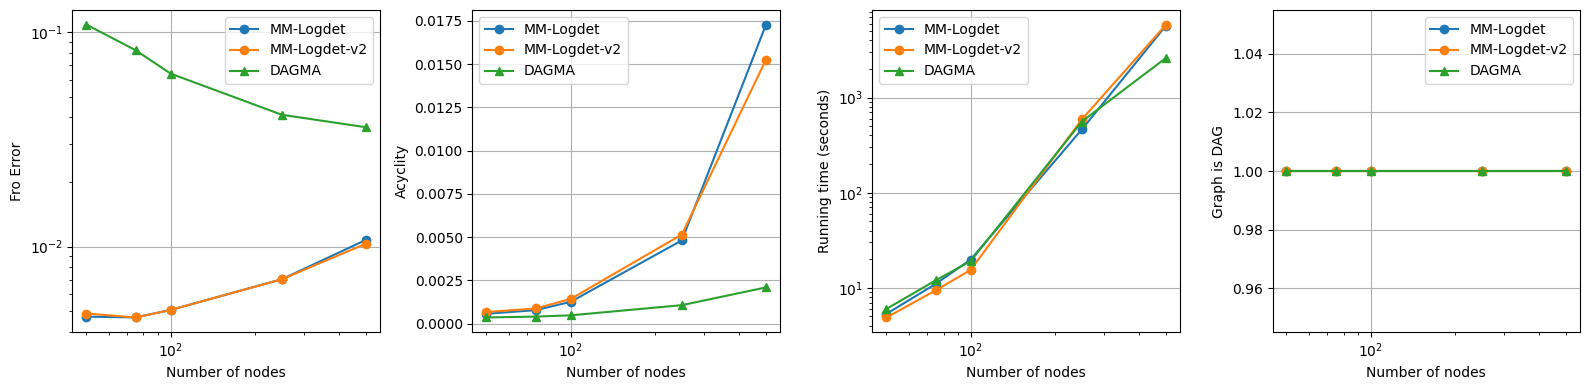

In [8]:
# # Load Data
# file_name = "./results/size/size_ERgraph_4N.npz" 
# # file_name = "./results/size/size_ERgraph_4N_1.5w.npz"
# data = np.load(file_name, allow_pickle=True)
# Exps, shd_er4, tpr_er4, fdr_er4, fscore_er4, err_er4, acyc_er4, runtime_er4, dag_count_er4, Sizes = data['exps'], data['shd'], data['tpr'], \
#     data['fdr'], data['fscore'], data['err'], data['acyc'], data['runtime'], data['dag_count'], data['xvals'],

skip = [] # [2]

utils.plot_all_metrics(shd_er4, tpr_er4, fdr_er4, fscore_er4, err_er4, acyc_er4, runtime_er4, dag_count_er4, Sizes, Exps,
                 skip_idx=skip, agg='median', xlabel='Number of nodes')


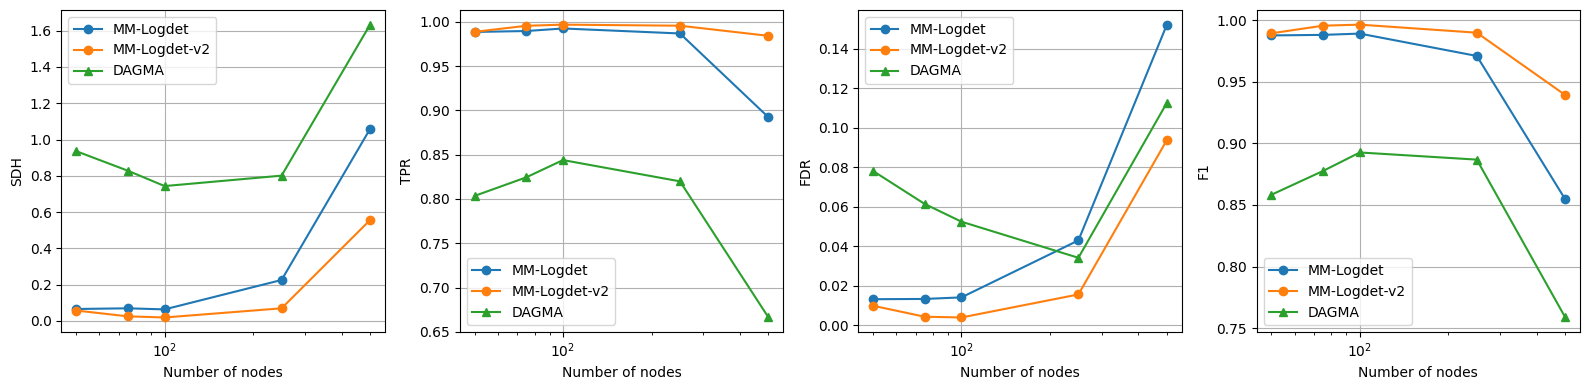

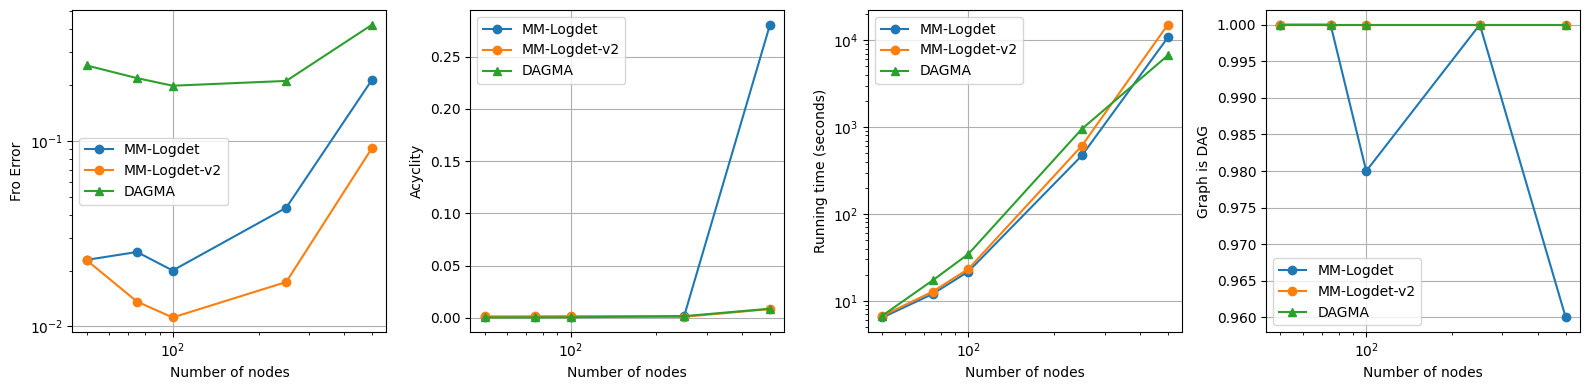

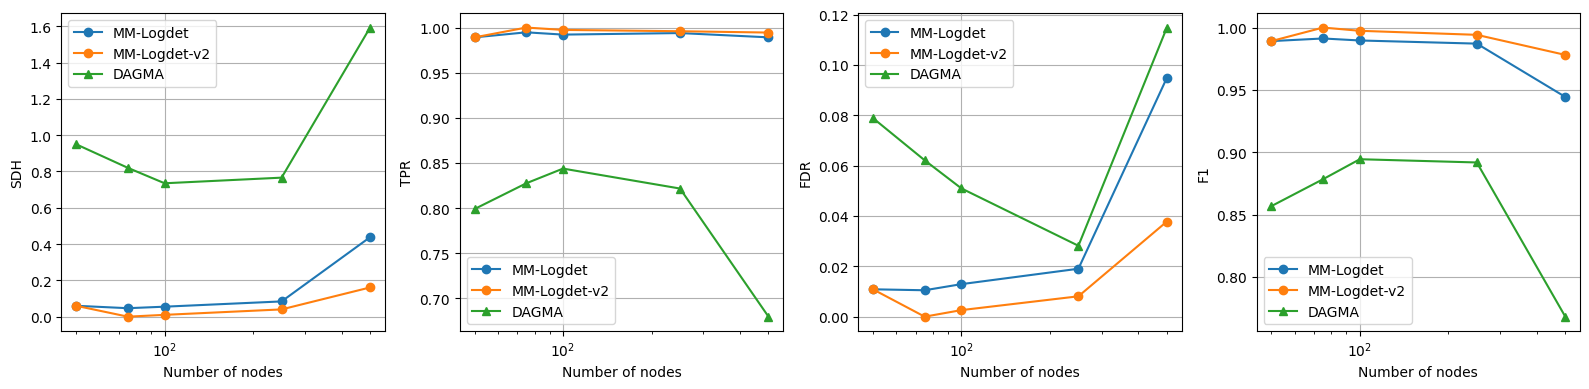

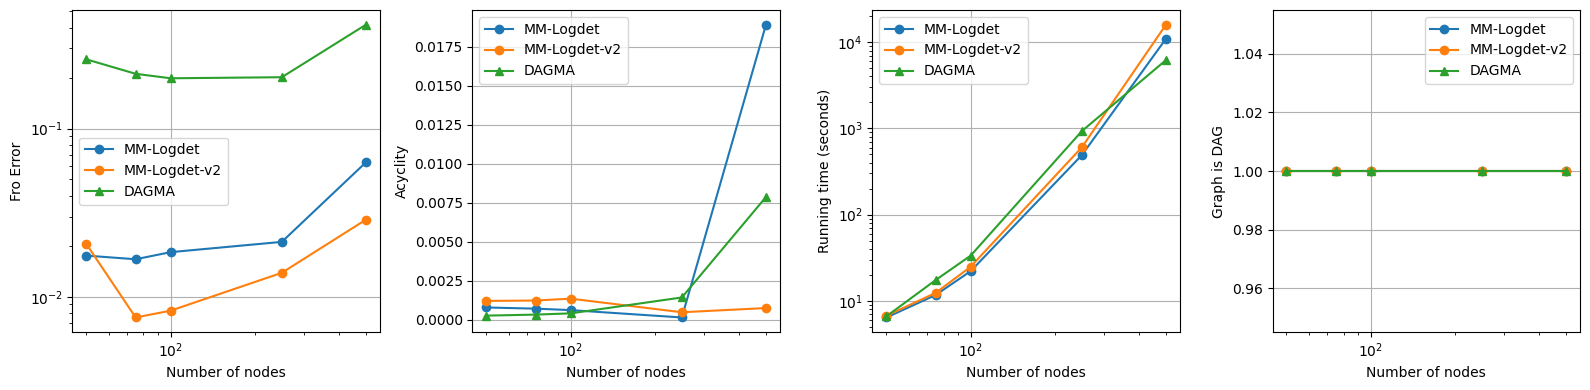

In [5]:
# # Load Data
# file_name = "./results/size/size_SFgraph_4N.npz"
# data = np.load(file_name, allow_pickle=True)
# Exps, shd_sf4, tpr_sf4, fdr_sf4, fscore_sf4, err_sf4, acyc_sf4, runtime_sf4, dag_count_sf4, Sizes = data['exps'], data['shd'], data['tpr'], \
#     data['fdr'], data['fscore'], data['err'], data['acyc'], data['runtime'], data['dag_count'], data['xvals'],

skip = [] # [2]

utils.plot_all_metrics(hd_sf4, tpr_sf4, fdr_sf4, fscore_sf4, err_sf4, acyc_sf4, runtime_sf4, dag_count_sf4, Sizes, Exps,
                 skip_idx=skip, agg='median', xlabel='Number of nodes')
